In [1]:
import geopandas as gpd
import numpy as np

input_shapefile = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/AOIs/NSW_declared_8July_Merge.shp"

lgas = gpd.read_file(input_shapefile).to_crs("EPSG:4326")
lgas_bounds = lgas.bounds
bounds_all = np.min(lgas_bounds.minx), np.min(lgas_bounds.miny), np.max(lgas_bounds.maxx), np.max(lgas_bounds.maxy)
bounds_all

(147.09959654580408,
 -35.644618412374655,
 153.02036310173182,
 -30.402318245783633)

<AxesSubplot:>

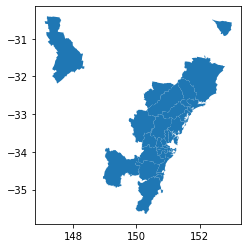

In [2]:
lgas.plot()

## Compute existing polygons

In [3]:
import os
from ml4floods.data import utils
from tqdm import tqdm

In [4]:
# Access parameters for ML4CC bucket
key_json = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/ml4cc-general-access_request_pays.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_json
fs = utils.get_filesystem("gs://ml4cc_data_lake")

# Read existing polygons from pickles on bucket
data = []
for meta_file in tqdm(fs.glob("gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR586/*/flood_meta/2022-07-*")):
    meta_file = f"gs://{meta_file}"
    meta = utils.read_pickle_from_gcp(meta_file)
    data.append({"geometry":meta["area_of_interest_polygon"], "ems_code":meta["ems_code"], "aoi_code":meta["aoi_code"], "date":meta["satellite date"]})
data = gpd.GeoDataFrame(data,crs="EPSG:4326")
data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [02:08<00:00,  1.70it/s]


,geometry,ems_code,aoi_code,date
0,"POLYGON ((147.09960 -31.24462, 147.30960 -31.2...",EMSR586,AOI01,2022-07-05
1,"POLYGON ((147.09960 -31.04462, 147.30960 -31.0...",EMSR586,AOI02,2022-07-05
2,"POLYGON ((147.09960 -30.84462, 147.30960 -30.8...",EMSR586,AOI03,2022-07-05
3,"POLYGON ((147.09960 -30.64462, 147.30960 -30.6...",EMSR586,AOI04,2022-07-05
4,"POLYGON ((147.09960 -30.44462, 147.30960 -30.4...",EMSR586,AOI05,2022-07-05
...,...,...,...,...
213,"POLYGON ((150.29960 -34.64462, 150.50960 -34.6...",EMSR586,AOI95,2022-07-05
214,"POLYGON ((150.29960 -34.44462, 150.50960 -34.4...",EMSR586,AOI96,2022-07-05
215,"POLYGON ((150.29960 -34.24462, 150.50960 -34.2...",EMSR586,AOI97,2022-07-05
216,"POLYGON ((150.29960 -34.04462, 150.50960 -34.0...",EMSR586,AOI98,2022-07-05


<AxesSubplot:>

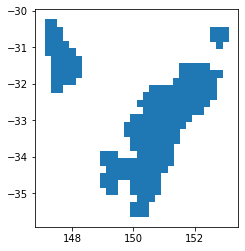

In [6]:
data.plot()

In [7]:
out_file = "/data1/ownCloud/2022-07-14_AU_Flood_Maps/AOIs_existing/2022-07-14_aois.geojson"
data[["geometry","aoi_code"]].to_file(out_file,driver="GeoJSON")

In [ ]:
import itertools
from ml4floods.data.copernicusEMS.activations import generate_polygon
from shapely.geometry import Polygon

import warnings
warnings.filterwarnings('ignore', 'Geometry is in a ', UserWarning)

step = 0.20, 0.20
size = 0.21

pols_all = []
for idx, (x_left,y_bottom) in enumerate(itertools.product(np.arange(bounds_all[0], bounds_all[2], step[0]),
                                                          np.arange(bounds_all[1],bounds_all[3], step[1]))):
    bounds_iter = (x_left, y_bottom, x_left+size, y_bottom+size)
    pol = Polygon(generate_polygon(bounds_iter))
    
    
    # TODO do not include pol if it does not overlap the lgas
    lgas_overlap_polygons = lgas.intersection(pol)
    lgas_overlap_polygons = lgas_overlap_polygons[~lgas_overlap_polygons.is_empty].copy()
    if lgas_overlap_polygons.shape[0] == 0:
        # print(f"{idx} does not overlap the LGAS")
        continue
    area_overlap_lga = lgas_overlap_polygons.area.sum() / pol.area
    
    if area_overlap_lga<=.3:
        continue
    
    # do not include pol if it has high overlap with existing polygons
    aoi_overlap_polygons = data.intersection(pol)
    aoi_overlap_polygons = aoi_overlap_polygons[~aoi_overlap_polygons.is_empty].copy()
    
    area_overlap = aoi_overlap_polygons.area.sum() / pol.area
    if area_overlap >=.3:
        # print(f"Do not include {idx}")
        continue
    
    pols_all.append({"geometry": pol, "name":f"AUTOAOI{idx:04d}"})
    
    
pols_all = gpd.GeoDataFrame(pols_all,crs="EPSG:4326")
print(pols_all.shape)
pols_all.to_file("/home/gonzalo/Downloads/autoaois.geojson",driver="GeoJSON")

In [ ]:
pol.area
existing_aois = .is_empty

In [ ]:
(153.3362,-28.1347) - (153.6401,-28.1467) - (153.3386,-28.3836)